In [1]:
from hypnospy import Wearable
from hypnospy.data import RawProcessing
from hypnospy.analysis import SleepBoudaryDetector

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates

import fitparse
import csv
from glob import glob
from os import path

import pytz
from datetime import timedelta

from collections import defaultdict


from pylab import rcParams

from tqdm import tqdm
from datetime import datetime, date, time, timedelta

plt.style.use('seaborn-poster')
%matplotlib inline

In [2]:
#allowed_fields = ['timestamp','timestamp_16', 'heart_rate','position_lat','position_long', 'distance',
 # 'enhanced_altitude', 'altitude','enhanced_speed',
#                 'speed']
required_fields = ['timestamp','timestamp_16','heart_rate']
UTC = pytz.UTC
GMT = pytz.timezone('Europe/London')

#fitfile = fitparse.FitFile(file,data_processor=fitparse.StandardUnitsDataProcessor())
def write_fitfile_to_csv(fitfile, output_file='test_output.csv'):
    messages = fitfile.messages
    data = []
    for m in messages:
        skip=False
        fields = m.fields
        #print(fields)
        #check for important data types
        mdata = {}
        for field in fields:
            if field.name in required_fields:
                 #if field.name=='timestamp':
                 #    mdata[field.name] = UTC.localize(field.value).astimezone(GMT)
                mdata[field.name] = field.value
        if bool(mdata) :
            data.append(mdata)
        #write to csv
    with open(output_file, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(required_fields)
        for entry in data:
            writer.writerow([ str(entry.get(k, '')) for k in required_fields])
    print('wrote %s' % output_file)

def garmin_clean_hr(file):

    plt.rcParams['figure.figsize'] = (14,8)

    df = pd.DataFrame(pd.read_csv(file+'.csv'))
    rate_stamp_df = pd.DataFrame(df[['timestamp_16','heart_rate']].dropna(axis=0, how='all'))
    rate_stamp_df['ts_diff'] = pd.to_timedelta(rate_stamp_df['timestamp_16'].diff(),unit='s')
    rate_stamp_df['id'] = range(len(rate_stamp_df))
    rate_stamp_df = rate_stamp_df.set_index(rate_stamp_df['id'])
    min_tsdif = rate_stamp_df['ts_diff'].min()
    idx_min = np.argmin(rate_stamp_df['ts_diff'])
    rate_stamp_df['heart_rate'][rate_stamp_df['heart_rate']<25] = np.nan
    rate_stamp_df['ts_diff'][idx_min] = 60
    rate_stamp_df['ts_diff'][rate_stamp_df['ts_diff'].isna()] = pd.Timedelta(seconds=0)
    rate_stamp_df['ts_diff'] = rate_stamp_df['ts_diff'].astype('timedelta64[s]')
    rate_stamp_df['ts'] = pd.Timestamp(df['timestamp'][0])
    rate_stamp_df['tscum'] = rate_stamp_df['ts_diff'].cumsum()
    rate_stamp_df['ts'] = rate_stamp_df['ts'] + rate_stamp_df['tscum']
    rate_stamp_df['pid']=0
    
    df_clean = pd.DataFrame(rate_stamp_df[['ts','heart_rate','pid']])
    df_clean['heart_rate'] = df_clean['heart_rate'].fillna(method='ffill')
    #plt.plot(rate_stamp_df['ts'], rate_stamp_df['heart_rate'])
    #plt.show()
    
    return df_clean

In [4]:
#To get .fit files go to Garmin Connect / health reports. There look up the HR plot and click on the settings icon in the
#upper right corner to download. Select biggest file from each day

csv_path = "./data/garmin/test_1/*.csv"
fit_path = "./data/garmin/test_1/*.fit"

#Read from own files
data = defaultdict(dict)

for idx, file in enumerate(glob(fit_path)):
    fitfile = fitparse.FitFile(file,data_processor=fitparse.StandardUnitsDataProcessor())
    write_fitfile_to_csv(fitfile, output_file=file+'.csv')
    data[idx] = garmin_clean_hr(file)
    
df_all = pd.concat([df for df in data.values()], axis=0).reset_index(drop=True)
df_all.set_index('ts',inplace=True)
#.fit files do not sample minute by minute, so I resampled and filled the missing values
df_all = df_all.resample('1T').mean().fillna(method='ffill').fillna(method='bfill')
df_all.to_csv('./data/garmin/test_1/hr_garmin.csv')

df_all = pd.DataFrame(pd.read_csv('./data/garmin/test_1/hr_garmin.csv')).reset_index(drop=True)
#df_all.set_index('ts',inplace=True)
#df_all.index = pd.to_datetime(df_all.index)
#df_all = df_all.reset_index()

print(df_all.head(5))
print(df_all.columns)


wrote ./data/garmin/test_1\56201616041.fit.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote ./data/garmin/test_1\56289086578.fit.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote ./data/garmin/test_1\56462913891.fit.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote ./data/garmin/test_1\56462941357.fit.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote ./data/garmin/test_1\56617084173.fit.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote ./data/garmin/test_1\56617121373.fit.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote ./data/garmin/test_1\56810312754.fit.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote ./data/garmin/test_1\56810343435.fit.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote ./data/garmin/test_1\56983966765.fit.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote ./data/garmin/test_1\56984000000.fit.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote ./data/garmin/test_1\57157607568.fit.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote ./data/garmin/test_1\57157646251.fit.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote ./data/garmin/test_1\57293624872.fit.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote ./data/garmin/test_1\57293654119.fit.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote ./data/garmin/test_1\57413437108.fit.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote ./data/garmin/test_1\57580527699.fit.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote ./data/garmin/test_1\57580569048.fit.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote ./data/garmin/test_1\57750255619.fit.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote ./data/garmin/test_1\57750282711.fit.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote ./data/garmin/test_1\57927948505.fit.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote ./data/garmin/test_1\57927985739.fit.csv
                    ts  heart_rate  pid
0  2020-05-17 23:00:00        46.0  0.0
1  2020-05-17 23:01:00        50.0  0.0
2  2020-05-17 23:02:00        46.0  0.0
3  2020-05-17 23:03:00        45.0  0.0
4  2020-05-17 23:04:00        55.0  0.0
Index(['ts', 'heart_rate', 'pid'], dtype='object')


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
data_path = "./data/garmin/test_1/hr_garmin.csv"
# Parameters for the HypnosPy HR-based sleep algorithm
hr_quantile = 0.4
hr_min_window_length = 40
hr_merge_blocks = 180

hr_volarity = 5
#Time to consider as start and end of each experiment day - if equal the sleep labelling occurs
#over the entire 24 hours
start_hour = 15
end_hour = 15


pp = RawProcessing(data_path,
                   device_location="dw", 
                   cols_for_activity=["heart_rate"], 
                   is_act_count=False,
                   col_for_datetime="ts",
                   strftime="%Y-%m-%d %H:%M:%S", 
                   col_for_pid="pid", 
                   col_for_hr=["heart_rate"])

w = Wearable(pp)

w.change_start_hour_for_experiment_day(15)

print(w.data.head(10))

sbd = SleepBoudaryDetector(w)

sbd.detect_sleep_boundaries(strategy="hr", output_col="hyp_sleep_period_hr", hr_quantile=hr_quantile,
                                hr_volarity_threshold=hr_volarity, hr_rolling_win_in_minutes=5,
                                hr_sleep_search_window=(start_hour, end_hour),
                                hr_min_window_length_in_minutes=hr_min_window_length,
                                hr_volatility_window_in_minutes=10, hr_merge_blocks_gap_time_in_min=hr_merge_blocks,
                                hr_sleep_only_in_sleep_search_window=False, hr_only_largest_sleep_period=False)

                    ts  heart_rate  pid  hyp_act_x        hyp_time_col  \
0  2020-05-17 23:00:00        46.0  0.0       46.0 2020-05-17 23:00:00   
1  2020-05-17 23:01:00        50.0  0.0       50.0 2020-05-17 23:01:00   
2  2020-05-17 23:02:00        46.0  0.0       46.0 2020-05-17 23:02:00   
3  2020-05-17 23:03:00        45.0  0.0       45.0 2020-05-17 23:03:00   
4  2020-05-17 23:04:00        55.0  0.0       55.0 2020-05-17 23:04:00   
5  2020-05-17 23:05:00        62.0  0.0       62.0 2020-05-17 23:05:00   
6  2020-05-17 23:06:00        54.0  0.0       54.0 2020-05-17 23:06:00   
7  2020-05-17 23:07:00        53.0  0.0       53.0 2020-05-17 23:07:00   
8  2020-05-17 23:08:00        49.0  0.0       49.0 2020-05-17 23:08:00   
9  2020-05-17 23:09:00        45.0  0.0       45.0 2020-05-17 23:09:00   

   hyp_exp_day  
0            0  
1            0  
2            0  
3            0  
4            0  
5            0  
6            0  
7            0  
8            0  
9            0 

ValueError: Incompatible indexer with Series

<Figure size 1008x576 with 0 Axes>

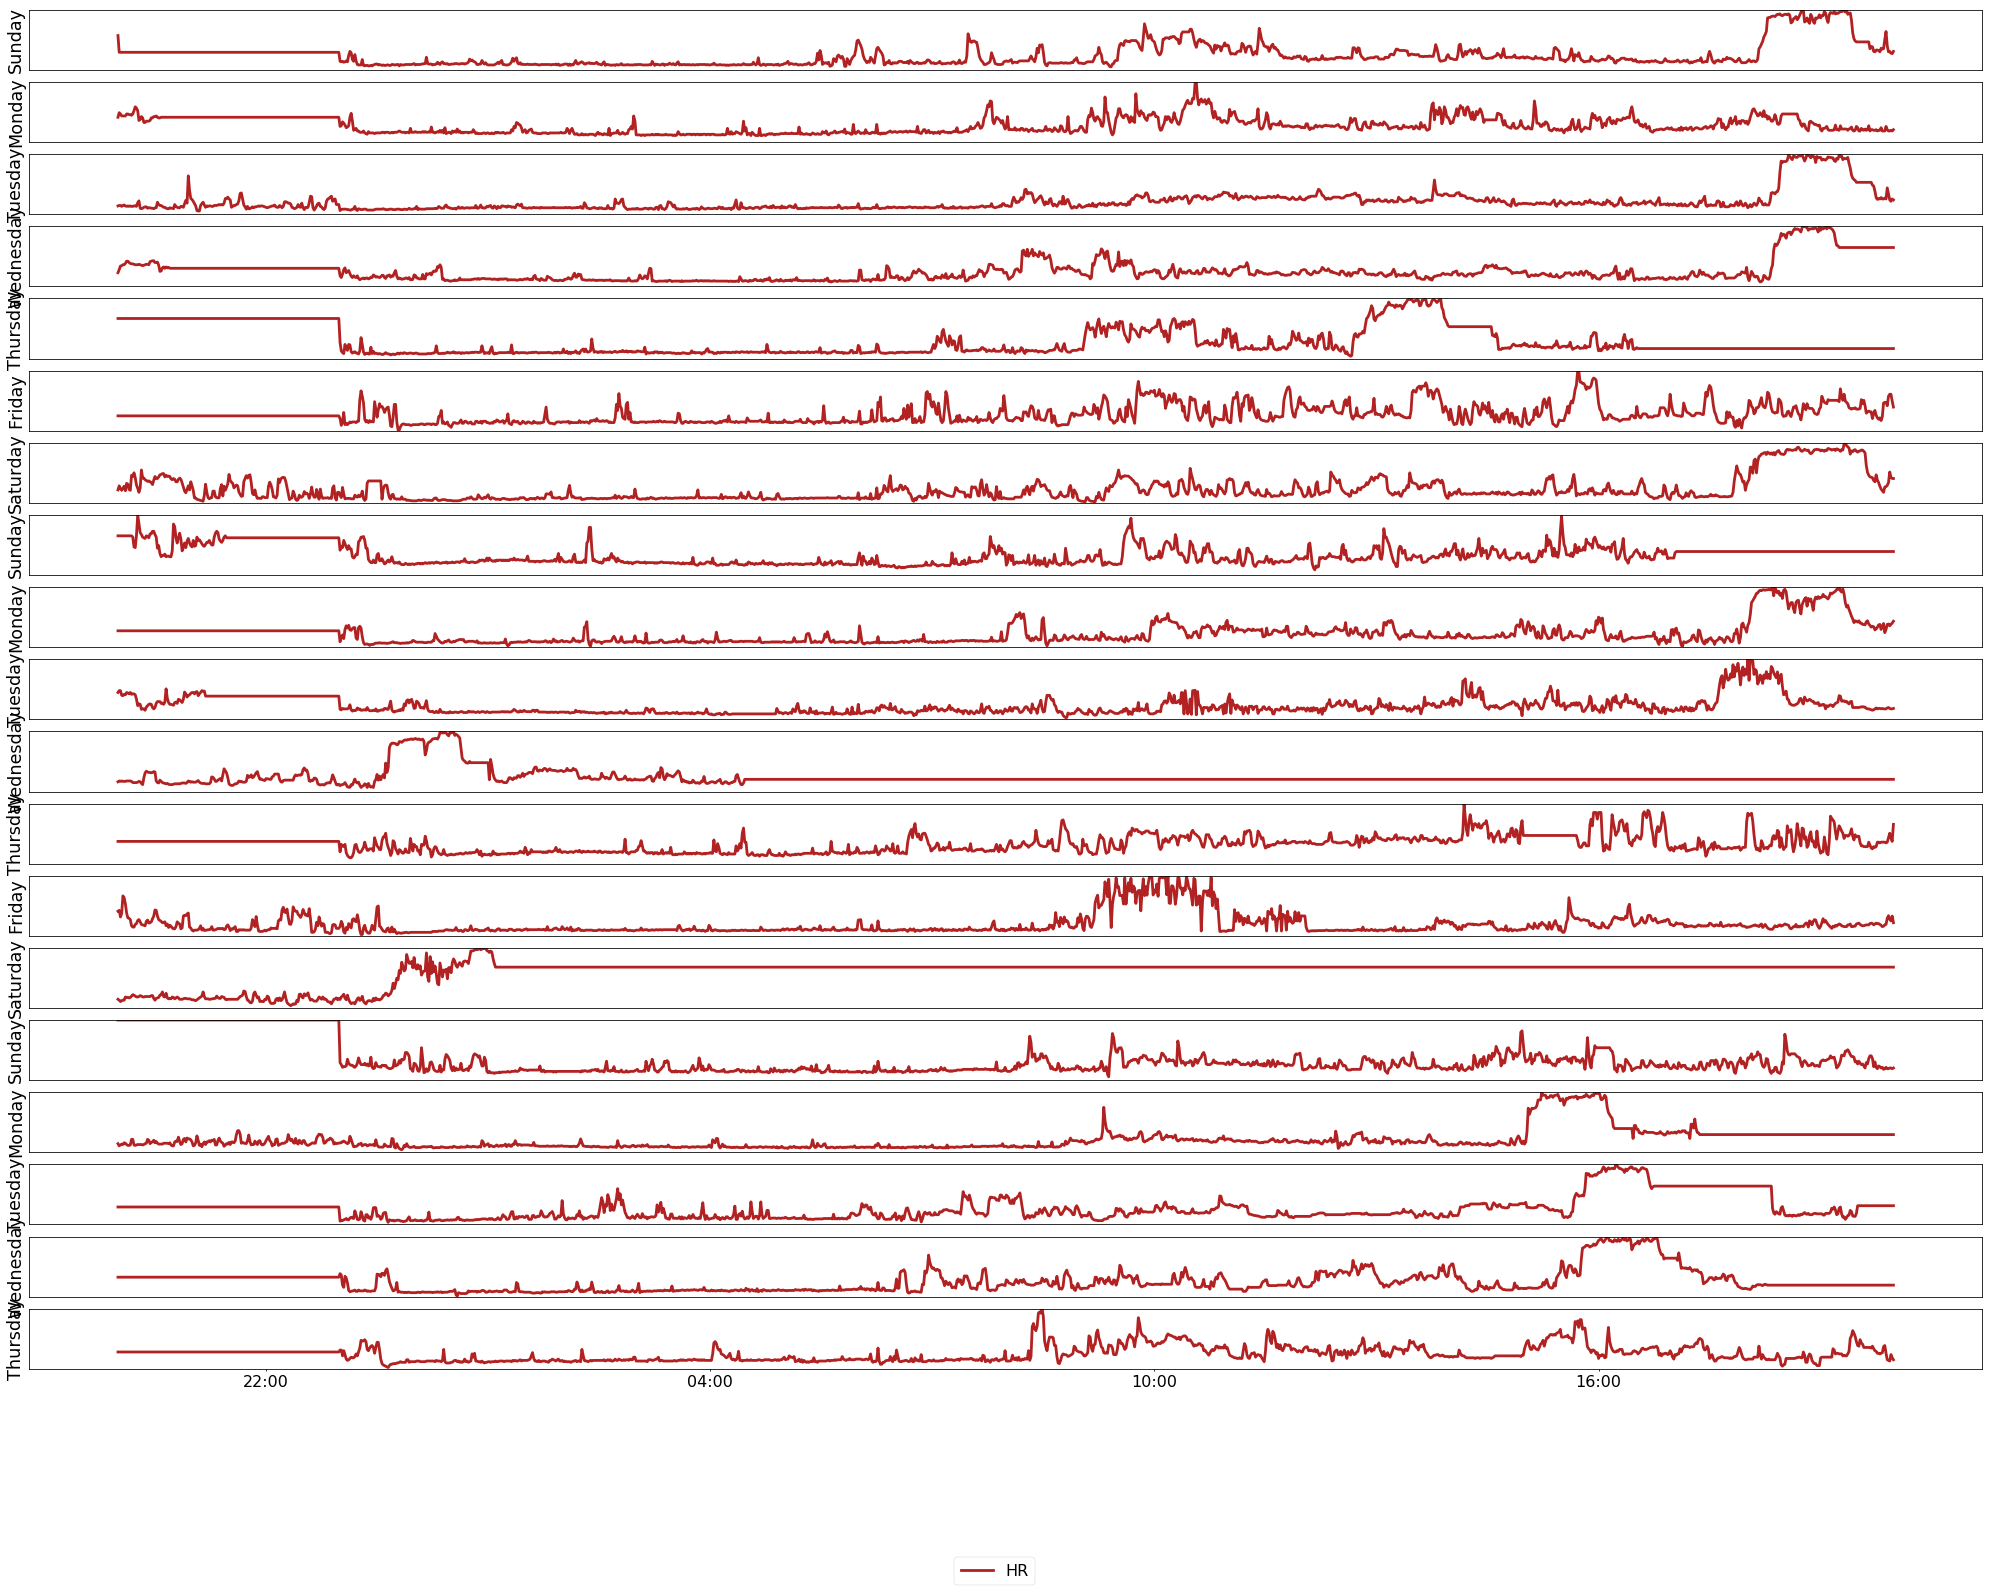

In [45]:
def plot_garmin(exp):
    plt.rcParams.update({'font.size': 20})
    fig,ax1 = plt.subplots(np.max(w.data['hyp_exp_day'])-1,1,figsize=(35,25))
    DFList = [pd.DataFrame(group[1]) for group in w.data.groupby(w.data['hyp_exp_day'])]
                      
    for jdx in range(len(DFList)-2):
        #Resampling: hourly
        df_day = DFList[jdx+1]
        ax1[jdx].plot(df_day['hyp_time_col'], df_day['heart_rate'], label='HR', color = 'firebrick')
        ax1[jdx].set_ylim(30, max(df_day['heart_rate']))
        ax1[jdx].set_xticks([])
        ax1[jdx].set_yticks([])
        ax1[jdx].set_ylabel(calendar.day_name[DFList[jdx]['hyp_time_col'][0+jdx*1440].dayofweek], rotation=90)
        #ax1[jdx].fill_between(df_day['hyp_time_col'], 0,
         #                df_day['hyp_sleep_period']*200, 
          #               color='royalblue',alpha=1, label='sleep window')
        
    ax1[-1].xaxis.set_minor_locator(dates.HourLocator(interval=6))   # every 4 hours
    ax1[-1].xaxis.set_minor_formatter(dates.DateFormatter('%H:%M')) # hours and minutes

    
    handles, labels = ax1[-1].get_legend_handles_labels()

    fig.legend(handles, labels, loc='lower center',ncol=4)
    return fig
plt.clf()
f = plot_garmin(w)
f.show()
#f.savefig('HRGarmin.png')